#### Objective: Visualizing activation maps after passing through a convolution layer

Activation maps represent which parts of the image the convolutional filters respond to.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision

from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [3]:
X_train = torch.tensor([[[[1,2,3,4], [2,3,4,5],
                         [5,6,7,8], [1,3,4,5]]],
                       [[[-1,2,3,-4], [2,-3,4,5],
                        [-5,6,-7,8],[-1,-3,-4,-5]]]]).to(device).float() # [batch_size x channels x height x width]
print(X_train.shape)
X_train = X_train/8 
y_train = torch.tensor([0,1]).to(device).float()
print(f'X_train:\n{X_train}')
print(f'y_train:\n{y_train}')

torch.Size([2, 1, 4, 4])
X_train:
tensor([[[[ 0.1250,  0.2500,  0.3750,  0.5000],
          [ 0.2500,  0.3750,  0.5000,  0.6250],
          [ 0.6250,  0.7500,  0.8750,  1.0000],
          [ 0.1250,  0.3750,  0.5000,  0.6250]]],


        [[[-0.1250,  0.2500,  0.3750, -0.5000],
          [ 0.2500, -0.3750,  0.5000,  0.6250],
          [-0.6250,  0.7500, -0.8750,  1.0000],
          [-0.1250, -0.3750, -0.5000, -0.6250]]]], device='cuda:0')
y_train:
tensor([0., 1.], device='cuda:0')


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3) # input should have 1 channel, output of this conv will have 1 channel too
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1, 1)  
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [5]:
model = SimpleCNN().to(device)
criterion = nn.BCELoss()  # for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# hook to capture activation map
activation = {}

def get_activation(name):
    def hook(model, input_, output_):
        activation[name] = output_.detach()
    return hook 

### Hook:
Hook function in PyTorch allow to intercept output of a specific layer in a NN. i.e. Capturing intermediate activations of a layer while network is processing data. 

In [7]:
model.conv1.register_forward_hook(get_activation('conv1'))

In [9]:
output = model(X_train)
output.shape 

torch.Size([2, 1])

In [10]:
def plot_activation_maps(activation, num_images=2):
    # activation maps for each image in the batch
    fig, axes = plt.subplots(num_images, 1, figsize=(4, 4*num_images))
    for i in range(num_images):
        act = activation['conv1'][i].cpu().squeeze()  # remove batch and channel dimensions
        if num_images == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(act, cmap='viridis')
        ax.set_title(f'Activation Map for Sample {i+1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

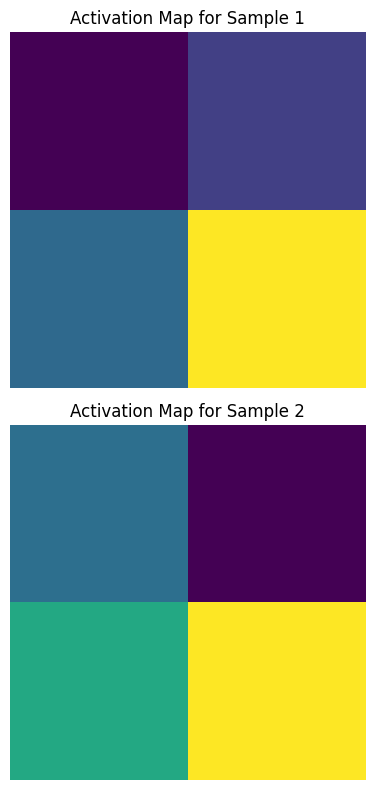

In [11]:
plot_activation_maps(activation, num_images=2)

For more complex dataset

In [37]:
def create_shape_dataset(size=32, num_samples=10):
    images, labels = [], []
    for _ in range(num_samples):
        shape = np.random.choice(['circle', 'square'])
        img = np.zeros((size, size), dtype=np.float32)
        if shape == 'circle':
            rr, cc = np.ogrid[:size, :size]
            mask = (rr - size // 2) ** 2 + (cc - size // 2) ** 2 <= (size // 4) ** 2
            img[mask] = 1
            labels.append(0)  # 0 for circle
        else:
            img[size // 4:size * 3 // 4, size // 4:size * 3 // 4] = 1
            labels.append(1)  # 1 for square
        images.append(img)
    return torch.tensor(images).unsqueeze(1), torch.tensor(labels)

images, labels = create_shape_dataset(num_samples=4)
print("Generated dataset shape:", images.shape)

Generated dataset shape: torch.Size([4, 1, 32, 32])


In [30]:
class SimpleCNN2(nn.Module):
    def __init__(self):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)  # 4 filters
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        return x

In [31]:
model = SimpleCNN2()

activations = {}
def hook_fn2(module, input, output):
    activations['conv1'] = output

model.conv1.register_forward_hook(hook_fn2)

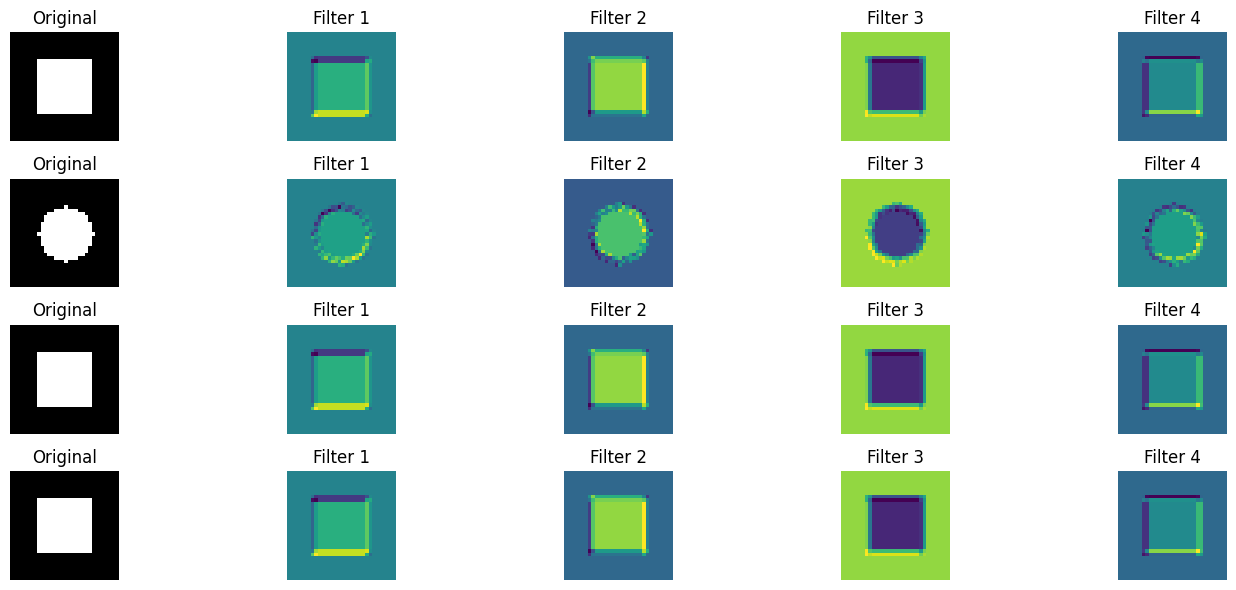

In [36]:
model(images)

fig, axes = plt.subplots(len(images), 5, figsize=(15, 6))

for i in range(len(images)):
    axes[i, 0].imshow(images[i].squeeze(), cmap="gray")
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")
    
    for j in range(4):
        activation_map = activations['conv1'][i, j].detach().numpy()
        axes[i, j+1].imshow(activation_map, cmap="viridis")
        axes[i, j+1].set_title(f"Filter {j+1}")
        axes[i, j+1].axis("off")

plt.tight_layout()
plt.show()


For ellipse in the image

In [33]:
def generate_varied_image():
    img = np.zeros((32, 32), dtype=np.float32)
    
    # a gradient from left to right 
    img[:, :16] = np.linspace(0, 1, 16)
    img[:, 16:] = np.linspace(1, 0, 16)
    
    # diagonal line
    for i in range(0, 32, 4):
        img[i:i+2, :] = 0.5  # horizontal stripes
    
    # ellipse in center
    rr, cc = np.ogrid[:32, :32]
    mask = ((rr - 16) ** 2 / 64 + (cc - 16) ** 2 / 64) <= 1
    img[mask] = 0.8  
    
    return torch.tensor(img).unsqueeze(0).unsqueeze(0)
    
image = generate_varied_image()

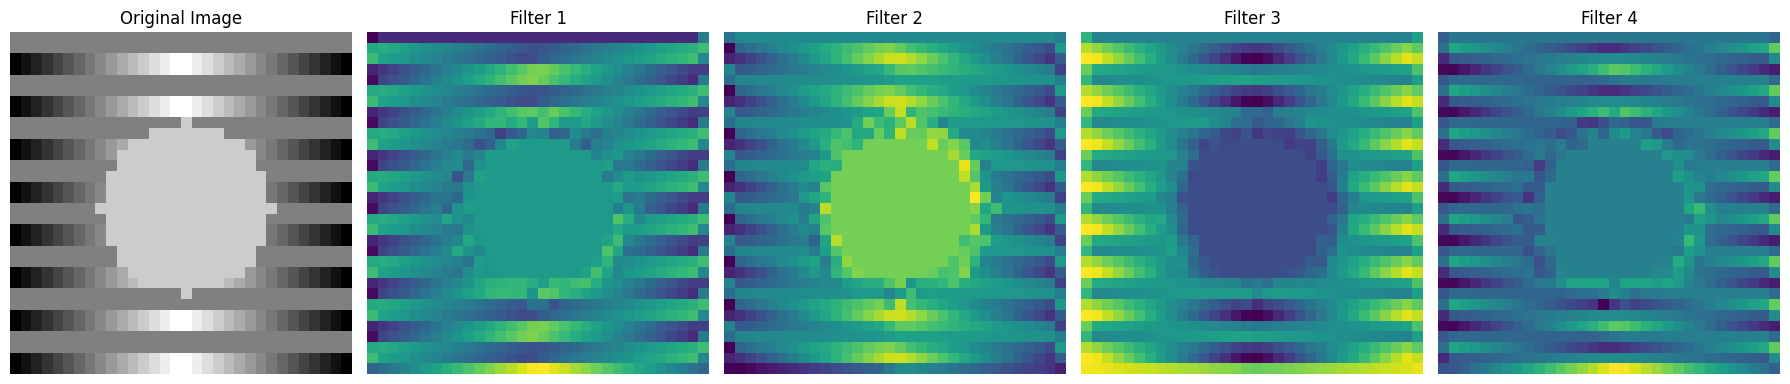

In [35]:
model(image)

fig, axes = plt.subplots(1, 5, figsize=(18, 6))

axes[0].imshow(image.squeeze(), cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

for i in range(4):
    activation_map = activations['conv1'][0, i].detach().numpy()
    axes[i + 1].imshow(activation_map, cmap="viridis")
    axes[i + 1].set_title(f"Filter {i+1}")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()

Here, 4 different filters are seen giving 4 different maps of the original image. Such more filters help understand and capture more features from an image. Thus, we can understand how CNN is processing the image and the features it is learning to detect.